In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
class player(object):
    def __init__(self, num_arm, true_prefer):
        self.num_arm = num_arm
        self.count = np.zeros(num_arm)
        self.prefer = np.zeros(num_arm)
        self.inf = 1000000
        self.ranking = np.ones(num_arm) * self.inf
        self.true_prefer = true_prefer

    def reinit(self):
        self.count = np.zeros(self.num_arm)
        self.prefer = np.zeros(self.num_arm)
        self.ranking = np.ones(self.num_arm) * self.inf

    def update(self, reward, arm_index, round):
        self.count[arm_index] += 1
        self.prefer[arm_index] += 1/self.count[arm_index] * (reward - self.prefer[arm_index])
        self.ranking[arm_index] = self.prefer[arm_index] + np.sqrt(3 * np.log(round) / (2 * self.count[arm_index]))
    
    def rankings(self):
        return np.argsort(-self.ranking)

class player_trueprefer(object):
    def __init__(self, num_arm, true_prefer):
        self.num_arm = num_arm
        self.count = np.zeros(num_arm)
        self.prefer = np.zeros(num_arm)
        self.inf = 1000000
        self.ranking = np.ones(num_arm) * self.inf
        self.true_prefer = true_prefer

    def reinit(self):
        self.count = np.zeros(self.num_arm)
        self.prefer = np.zeros(self.num_arm)
        self.ranking = np.ones(self.num_arm) * self.inf

    def update(self, reward, arm_index, round):
        self.count[arm_index] += 1
        self.prefer[arm_index] += 1/self.count[arm_index] * (reward - self.prefer[arm_index])
        self.ranking[arm_index] = self.prefer[arm_index] + np.sqrt(3 * np.log(round) / (2 * self.count[arm_index]))
    
    def rankings(self):
        return self.true_prefer

In [3]:
class arm(object):
    def __init__(self, num_player, mean, var, ranking):
        self.num_player = num_player
        self.mean = mean
        self.var = var
        self.ranking = ranking

    def rankings(self):
        return self.ranking
    
    def gene_reward(self, player_num):
        return np.random.normal(self.mean[player_num], self.var)

In [37]:
class platform(object):
    def __init__(self, num_players, num_arms):
        self.num_players = num_players
        self.num_arms = num_arms
        self.round = 0 
    
    def update_round(self):
        self.round += 1

    def GS(self, players, arms):
        self.update_round()

        players_to_arms = np.zeros([self.num_players, self.num_arms])
        arms_to_players = np.zeros([self.num_arms, self.num_players])
        for i in range(self.num_players):
            players_to_arms[i] = players[i].rankings()
        for i in range(self.num_arms):
            arms_to_players[i] = arms[i].rankings()
        # trajectory records the proposing, match_or_not record single or not, 
        # match_buffer records all people who propose same arm
        trajectory = np.zeros(self.num_players, int)
        matching_or_not = np.zeros(self.num_players)
        matching_buffer = []
        for i in range(self.num_arms):
            matching_buffer.append([])

        #print(players_to_arms)
        while True:
            if np.sum(matching_or_not) == self.num_players:
                break
            #firstly let all plasyers propose
    
            for p in range(self.num_players):
                if matching_or_not[p] == 0:
                    p_choice = int(players_to_arms[p][trajectory[p]])
                    matching_buffer[p_choice].append(p)
            #secondly each arm needs to choose the best
            for a in range(len(arms)):
                if len(matching_buffer[a]) != 0:
                    #get the best choice
                    for i in range(self.num_players):
                        flag = False
                        for j in matching_buffer[a]:
                            flag = (arms_to_players[a][i] == j)
                            if flag == True:
                                break
                        if flag == True:
                            a_choice = arms_to_players[a][i]
                            break

                    #update player
                    for p_ in matching_buffer[a]:
                        if p_ == a_choice:
                            matching_or_not[p_] = 1
                        else:
                            matching_or_not[p_] = 0
                            trajectory[p_] += 1

                    #update arm
                    matching_buffer[a] = [int(a_choice)]
        
        #print(players[2].ranking)
        #print(matching_buffer)
        return matching_buffer

    def single_round(self, players, arms):
        matching_buffer = self.GS(players, arms)
        #print(matching_buffer)
        for i, a in enumerate(matching_buffer):
            reward = arms[i].gene_reward(int(a[0]))
            players[int(a[0])].update(reward, i, self.round)
        #print(players[2].ranking)
        return matching_buffer

    def multi_round(self, players, arms, rounds):
        regrets = []
        ranks = np.zeros([rounds, self.num_arms])
        for i in range(self.num_players):
            regrets.append([])

        for i in range(rounds):
            single_match = self.single_round(players, arms)
            ranks[i] = players[2].ranking
            for p in range(len(single_match)):
                optimal_arm = players[p].true_prefer[0] 
                selected_arm = single_match[p][0]
                p_regret = arms[optimal_arm].mean[p] - arms[selected_arm].mean[p]
                regrets[p].append(p_regret)

        regrets = np.cumsum(np.array(regrets), axis=1)
        return regrets, ranks

    def multi_exp(self, players, arms, rounds, exp_times):
        regrets = np.zeros([self.num_players, rounds])
        ranks = np.zeros([rounds, self.num_arms])
        
        for i in range(exp_times):
            _x, _y = self.multi_round(players, arms, rounds)
            regrets += _x / exp_times
            ranks += _y / exp_times
            self.reinit(players)

        #self.plot(regrets)
        print(ranks[:].shape)
        plt.plot(ranks[:-1][0])
        
    def reinit(self, players):
        self.round = 0
        for i in range(self.num_players):
            players[i].reinit()

    def plot(self, regrets):
        plt.figure(dpi=150)
        plt.plot(regrets[0], color = 'dodgerblue', linewidth = 0.8, label = 'Agent 1')
        plt.plot(regrets[1], color = 'lightskyblue', linewidth = 0.8, label = 'Agent 2')
        plt.plot(regrets[2], color = 'r', linewidth = 0.8, label = 'Agent 3')
        plt.ylabel('Expected Regret')
        plt.xlabel('Time')
        plt.legend()

    def plot_p3(self, ranks):
        plt.figure(dpi=150)
        plt.plot(ranks, color = 'dodgerblue', linewidth = 0.8, label = 'Agent 1')
        plt.plot(regrets[1], color = 'lightskyblue', linewidth = 0.8, label = 'Agent 2')
        plt.plot(regrets[2], color = 'r', linewidth = 0.8, label = 'Agent 3')
        plt.ylabel('Expected Regret')
        plt.xlabel('Time')
        plt.legend()

In [38]:
NUM_PLAYERS = 3
NUM_ARMS = 3
MEAN_ARMS =[[2,1,1.95],[1,2,0],[0,0,2]]
PLAYERS_TO_ARMS_RANKINGS = [[0,1,2], [1,0,2], [2,0,1]]
ARMS_TO_PLAYERS_RANKINGS = [[1,2,0], [0,1,2], [2,0,1]]
players = []
for i in range(NUM_PLAYERS - 1):
    players.append(player_trueprefer(NUM_ARMS, PLAYERS_TO_ARMS_RANKINGS[i]))
players.append(player(NUM_ARMS, PLAYERS_TO_ARMS_RANKINGS[2]))
players[2].ranking = np.array([2.2,0,0.5])

arms = []
for i in range(NUM_ARMS):
    arms.append(arm(NUM_PLAYERS, MEAN_ARMS[i], 1, ARMS_TO_PLAYERS_RANKINGS[i]))

(200, 3)


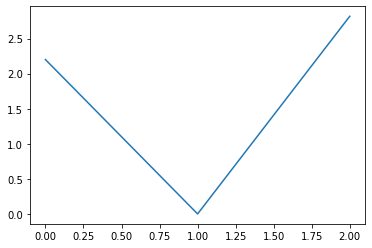

In [39]:
GSplatform = platform(NUM_PLAYERS, NUM_ARMS)
GSplatform.multi_exp(players, arms, 200, 1)